In [8]:
# Classification of EyeTracking Data
# Dirk Guetlin

import os
import os.path as op

import matplotlib.pyplot as plt
import numpy as np

import sys
module_path = op.abspath("/net/store/nbp/projects/MindQ/src/")
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas

from mindq_nslr.io import load_mindq, crop_df, save_pickle, add_events, add_segmentation
from mindq_nslr.utils import mark_by_distance
from mindq_nslr.classification import preprocess
from nbp_cateye.visualization import plot_segmentation, plot_nslr_segmentation
from nbp_cateye.cateye import classify_nslr_hmm, classify_remodnav
from nbp_cateye.utils import discrete_to_continuous, continuous_to_discrete

# Change only these parameters during classification
eye = "RightEye"
condition = "concussion"

### define directories
file_dir = op.join("/net/store/nbp/projects/MindQ/data", condition)
result_dir = op.join("/net/store/nbp/projects/MindQ/results", condition)
sub_dirs = [i[:36] for i in os.listdir(op.join(file_dir, eye))][:1]  # !!!remve before deployment
sub_dir = sub_dirs[0]

# load the data and events
df = load_mindq(op.join(file_dir, eye, sub_dir + "_" + eye + ".csv"))
event_df = pandas.read_csv(op.join(file_dir, "Events", sub_dir + "_Events.csv"))

# mark blinks by distance from recording
df["Blink"] = mark_by_distance(df, ["Theta", "Phi"], percentile=99.)

# preprocess the data by interpolating constants, boxcar smoothing and 
df = preprocess(df, ["Theta", "Phi"])

# crop the df
start = event_df["Timestamp"][15] #15
stop = event_df["Timestamp"][40]  #40
df = crop_df(df, start, stop)
event_df = crop_df(event_df, start, stop)

# classify the data using nslr_hmm
segments, classes, seg = classify_nslr_hmm(df["Theta"], df["Phi"], df["Timestamp"], return_segment_dict=True, optimize_noise=False)

/net/store/nbp/projects/MindQ/src/mindq_nslr/utils.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][mask] = np.nan
/net/store/nbp/projects/MindQ/programming_tools/miniconda3/envs/mne/lib/python3.7/site-packages/nslr_hmm/nslr_hmm.py:301: RuntimeWarning: invalid value encountered in true_divide
  direction = speed/velocity
/net/store/nbp/projects/MindQ/src/nbp_cateye/utils.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indices[selected] = cur_idx
/net/store/nbp/projects/MindQ/src/nbp_cateye/utils.py:17: FutureWarning: Using a non-tuple sequence for multidimens

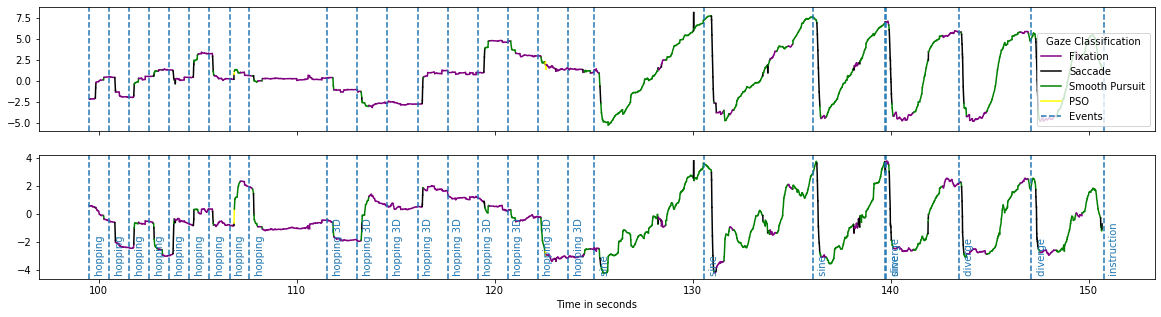

In [9]:
c_dict = {'Fixation': 'purple',
          'Saccade': 'black',
          'Smooth Pursuit': 'green',
          'PSO': 'yellow',
          'None':'grey',}

dis_seg_class = continuous_to_discrete(df["Timestamp"], segments, classes)
dis_events = (event_df["Timestamp"], event_df["Name"])

fig, axes = plt.subplots(2, figsize=(20, 5), sharex=True)
plot_segmentation(df["Theta"], df["Timestamp"], dis_seg_class, dis_events, show_event_text=False, ax=axes[0],
                 color_dict = c_dict)
plot_segmentation(df["Phi"], df["Timestamp"], dis_seg_class, dis_events, show_legend=False, ax=axes[1], color_dict=c_dict)
axes[1].set_xlabel("Time in seconds");

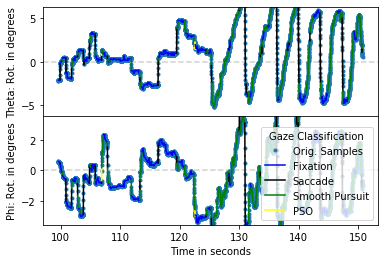

In [10]:
gaze_array = df[["Theta", "Phi"]].to_numpy()
time_array = df["Timestamp"].to_numpy()

plot_nslr_segmentation(time_array, gaze_array, seg["segmentation"], seg["seg_class"])

In [11]:
# degrees(atan2(.5 * screen_size, viewing_distance)) / (.5 * screen_resolution)

In [12]:
sfreq = 200  # Hertz

df_rs = df.copy()
df_rs.index = pandas.to_timedelta(df_rs["Timestamp"], unit="S")
df_rs = df_rs.resample(f"{1/sfreq}S").mean().ffill()

segments, classes = classify_remodnav(df_rs["Theta"], df_rs["Phi"], df_rs["Timestamp"], px2deg=1,
                                      #classifier_kwargs=dict(pursuit_velthresh=2.0),
                                     preproc_kwargs=dict(savgol_polyord=1), simple_output=True)

/net/store/nbp/projects/MindQ/src/nbp_cateye/cateye.py:64: UserWarning: 

Irregular sampling rate detected. This can lead to impaired performance with this classifier. Consider resampling your data to a fixed sampling rate. Setting sampling rate to average sample difference.
  warnings.warn("\n\nIrregular sampling rate detected. This can lead to impaired performance "
/net/store/nbp/projects/MindQ/src/nbp_cateye/utils.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indices[selected] = cur_idx
/net/store/nbp/projects/MindQ/src/nbp_cateye/utils.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`,

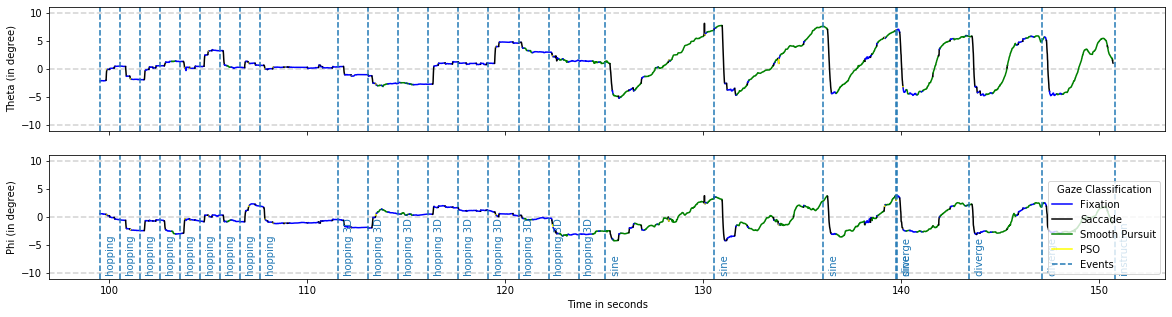

In [13]:
dis_seg_class = continuous_to_discrete(df_rs["Timestamp"], segments, classes)
dis_events = (event_df["Timestamp"], event_df["Name"])

fig, axes = plt.subplots(2, figsize=(20, 5), sharex=True)
for ax in axes:
        ax.axhline(y=0, color="lightgray", linestyle="--")
        ax.axhline(y=-10, color="lightgray", linestyle="--")
        ax.axhline(y=10, color="lightgray", linestyle="--")
        
plot_segmentation(df_rs["Theta"], df_rs["Timestamp"], dis_seg_class, dis_events, show_event_text=False, 
                  show_legend=False, ax=axes[0])
plot_segmentation(df_rs["Phi"], df_rs["Timestamp"], dis_seg_class, dis_events, ax=axes[1])

axes[0].set_ylabel("Theta (in degree)");
axes[1].set_ylabel("Phi (in degree)");   
axes[1].set_xlabel("Time in seconds");